# Prédiction des réservation clients

On commence par initialiser les environnements d'exécution et importer les modules nécessaires de Pyspark.!

###  Install Java, Spark, and Findspark
This installs Apache Spark 2.2.1, Java 8, and [Findspark](https://github.com/minrk/findspark), a library that makes it easy for Python to find Spark.

In [13]:
import tensorflow as tf


from google.colab import drive
drive.mount("/content/drive", force_remount=True)

!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/spark-2.3.2/spark-2.3.2-bin-hadoop2.7.tgz
!tar xf spark-2.3.2-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install h5py
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.3.2-bin-hadoop2.7"
import findspark
findspark.init()
from pyspark.sql import SparkSession
import pyspark
##Liste
from numpy import array
##Temps
import time
##Row and Vector
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors
##Hachage et vectorisation
from pyspark.ml.feature import HashingTF
from pyspark.ml.feature import IDF
##Regression logistique
from pyspark.ml.classification import LogisticRegression
##Decision Tree
from pyspark.ml.classification import DecisionTreeClassifier
##Random Forest
from pyspark.ml.classification import RandomForestClassifier 
##Pour la création des DataFrames
from pyspark.sql import SQLContext
from pyspark.sql.types import *

Mounted at /content/drive


In [0]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
conf1 = pyspark.SparkConf().setAll([('spark.executor.cores', '3'), ('spark.cores.max', '6'),('spark.driver.memory','1g')])
spark = SparkSession.builder.config(conf=conf1).config('yarn-client','pyspark').getOrCreate()

### Début du projet!


In [0]:
##Liste
from numpy import array
##Temps
import time
##Row and Vector
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors
##Hachage et vectorisation
from pyspark.ml.feature import HashingTF
from pyspark.ml.feature import IDF
##Regression logistique
from pyspark.ml.classification import LogisticRegression
##Decision Tree
from pyspark.ml.classification import DecisionTreeClassifier
##Random Forest
from pyspark.ml.classification import RandomForestClassifier 
##Pour la création des DataFrames
from pyspark.sql import SQLContext
from pyspark.sql.types import *

In [0]:
# TO DO
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()


In [0]:
file="drive/My Drive/PLP project/Dreem/train.csv"

sqlContext=SQLContext(spark)
tmps1=time.clock()
train=sqlContext.read.format('com.databricks.spark.csv').options(delimiter=",").load(file, header = True)
tmps2=time.clock()

# Exploration et analyse des données

Dans cette partie, nous explorons les données pour comprendre la structure de l'échantillon

In [20]:
print("########### Chargement des données train avec Spark en ", tmps2-tmps1," ############")

########### Chargement des données train avec Spark en  0.0019759999999999778  ############


In [21]:
train.show()

+-------------------+---------+--------------+---------------------+--------------------+------------------+-------------------------+-------+---------+----------+-------+----------+----------+---------------+-----------------+-----------+-------------------+------------------------+----------+---+---------------+-------------+------------+-------------+
|          date_time|site_name|posa_continent|user_location_country|user_location_region|user_location_city|orig_destination_distance|user_id|is_mobile|is_package|channel|   srch_ci|   srch_co|srch_adults_cnt|srch_children_cnt|srch_rm_cnt|srch_destination_id|srch_destination_type_id|is_booking|cnt|hotel_continent|hotel_country|hotel_market|hotel_cluster|
+-------------------+---------+--------------+---------------------+--------------------+------------------+-------------------------+-------+---------+----------+-------+----------+----------+---------------+-----------------+-----------+-------------------+------------------------+--

In [22]:
tmps3=time.clock()
l= train.count()
tmps4=time.clock()
print("Le calcul de", l, " lignes a pris ", tmps4-tmps3)

Le calcul de 37670293  lignes a pris  0.020807000000000464


In [23]:
len(train.columns), train.columns

(24,
 ['date_time',
  'site_name',
  'posa_continent',
  'user_location_country',
  'user_location_region',
  'user_location_city',
  'orig_destination_distance',
  'user_id',
  'is_mobile',
  'is_package',
  'channel',
  'srch_ci',
  'srch_co',
  'srch_adults_cnt',
  'srch_children_cnt',
  'srch_rm_cnt',
  'srch_destination_id',
  'srch_destination_type_id',
  'is_booking',
  'cnt',
  'hotel_continent',
  'hotel_country',
  'hotel_market',
  'hotel_cluster'])

In [0]:
from functools import reduce
train_nonan=train.na.drop()

In [25]:
train_nonan.count()

24117894

In [26]:
train_nonan.printSchema()

root
 |-- date_time: string (nullable = true)
 |-- site_name: string (nullable = true)
 |-- posa_continent: string (nullable = true)
 |-- user_location_country: string (nullable = true)
 |-- user_location_region: string (nullable = true)
 |-- user_location_city: string (nullable = true)
 |-- orig_destination_distance: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- is_mobile: string (nullable = true)
 |-- is_package: string (nullable = true)
 |-- channel: string (nullable = true)
 |-- srch_ci: string (nullable = true)
 |-- srch_co: string (nullable = true)
 |-- srch_adults_cnt: string (nullable = true)
 |-- srch_children_cnt: string (nullable = true)
 |-- srch_rm_cnt: string (nullable = true)
 |-- srch_destination_id: string (nullable = true)
 |-- srch_destination_type_id: string (nullable = true)
 |-- is_booking: string (nullable = true)
 |-- cnt: string (nullable = true)
 |-- hotel_continent: string (nullable = true)
 |-- hotel_country: string (nullable = true)
 

Nous remarquons que toutes les colonnes ont été lues comme étant de types String, il faut donc changer le type de certaines

# Changement du type des colonnes

In [0]:
from pyspark.sql.functions import col , column
train_nonan = train_nonan.withColumn("site_name", col("site_name").cast("int"))
train_nonan = train_nonan.withColumn("posa_continent", col("posa_continent").cast("int"))
train_nonan = train_nonan.withColumn("user_location_country", col("user_location_country").cast("int"))
train_nonan = train_nonan.withColumn("user_location_region", col("user_location_region").cast("int"))
train_nonan = train_nonan.withColumn("user_location_city", col("user_location_city").cast("int"))
train_nonan = train_nonan.withColumn("orig_destination_distance", col("orig_destination_distance").cast("double"))
train_nonan = train_nonan.withColumn("user_id", col("user_id").cast("int"))
train_nonan = train_nonan.withColumn("is_mobile", col("is_mobile").cast("tinyint"))
train_nonan = train_nonan.withColumn("is_package", col("is_package").cast("int"))
train_nonan = train_nonan.withColumn("channel", col("channel").cast("int"))
train_nonan = train_nonan.withColumn("srch_adults_cnt", col("srch_adults_cnt").cast("int"))
train_nonan = train_nonan.withColumn("srch_children_cnt", col("srch_children_cnt").cast("int"))
train_nonan = train_nonan.withColumn("srch_rm_cnt", col("srch_rm_cnt").cast("int"))
train_nonan = train_nonan.withColumn("srch_destination_id", col("srch_destination_id").cast("int"))
train_nonan = train_nonan.withColumn("srch_destination_type_id", col("srch_destination_type_id").cast("int"))
train_nonan = train_nonan.withColumn("hotel_continent", col("hotel_continent").cast("int"))
train_nonan = train_nonan.withColumn("hotel_country", col("hotel_country").cast("int"))
train_nonan = train_nonan.withColumn("hotel_market", col("hotel_market").cast("int"))
train_nonan = train_nonan.withColumn("is_booking", col("is_booking").cast("tinyint"))
train_nonan = train_nonan.withColumn("cnt", col("cnt").cast("bigint"))
train_nonan = train_nonan.withColumn("hotel_cluster", col("hotel_cluster").cast("int"))

## Nouveau Schéma (Les types ont bien été changés)

In [28]:
train_nonan.printSchema()

root
 |-- date_time: string (nullable = true)
 |-- site_name: integer (nullable = true)
 |-- posa_continent: integer (nullable = true)
 |-- user_location_country: integer (nullable = true)
 |-- user_location_region: integer (nullable = true)
 |-- user_location_city: integer (nullable = true)
 |-- orig_destination_distance: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- is_mobile: byte (nullable = true)
 |-- is_package: integer (nullable = true)
 |-- channel: integer (nullable = true)
 |-- srch_ci: string (nullable = true)
 |-- srch_co: string (nullable = true)
 |-- srch_adults_cnt: integer (nullable = true)
 |-- srch_children_cnt: integer (nullable = true)
 |-- srch_rm_cnt: integer (nullable = true)
 |-- srch_destination_id: integer (nullable = true)
 |-- srch_destination_type_id: integer (nullable = true)
 |-- is_booking: byte (nullable = true)
 |-- cnt: long (nullable = true)
 |-- hotel_continent: integer (nullable = true)
 |-- hotel_country: integer (nullable 

In [29]:
train_nonan.show()

+-------------------+---------+--------------+---------------------+--------------------+------------------+-------------------------+-------+---------+----------+-------+----------+----------+---------------+-----------------+-----------+-------------------+------------------------+----------+---+---------------+-------------+------------+-------------+
|          date_time|site_name|posa_continent|user_location_country|user_location_region|user_location_city|orig_destination_distance|user_id|is_mobile|is_package|channel|   srch_ci|   srch_co|srch_adults_cnt|srch_children_cnt|srch_rm_cnt|srch_destination_id|srch_destination_type_id|is_booking|cnt|hotel_continent|hotel_country|hotel_market|hotel_cluster|
+-------------------+---------+--------------+---------------------+--------------------+------------------+-------------------------+-------+---------+----------+-------+----------+----------+---------------+-----------------+-----------+-------------------+------------------------+--

In [30]:
 print("nombre de site_names ", train_nonan.select("site_name").distinct().count()) 

nombre de site_names  42


In [31]:
 print("Nombre de continents pris en compte dans la data ", train_nonan.select("posa_continent").distinct().count()) 

Nombre de continents pris en compte dans la data  5


In [32]:
print("Nombre des chaines de marketing ", train_nonan.select("channel").distinct().count()) 

Nombre des chaines de marketing  11


In [33]:
print("Nombre d'utilisateurs ", train_nonan.select("user_id").distinct().count()) 

Nombre d'utilisateurs  916154


In [0]:
freq_clusters=train_nonan.select("hotel_cluster").groupBy("hotel_cluster").count()

In [35]:
freq_clusters.show()

+-------------+------+
|hotel_cluster| count|
+-------------+------+
|           31|195728|
|           85|146323|
|           65|534791|
|           53| 67739|
|           78|171256|
|           34|244538|
|           81|129252|
|           28|373678|
|           76|199903|
|           26|282553|
|           27| 46267|
|           44|163845|
|           12| 77696|
|           91|829368|
|           22|170328|
|           93|144393|
|           47|322099|
|            1|352267|
|           52|262201|
|           13|253986|
+-------------+------+
only showing top 20 rows



La répartition des échantillons sur les clusters est plus ou moins équilibrée

In [0]:
import pyspark.sql.functions as F
import pyspark.sql as SQL
win = SQL.Window.partitionBy("hotel_cluster")

In [38]:
train_nonan.select(F.count("hotel_cluster").over(win).alias('histogram'))


DataFrame[histogram: bigint]

([<matplotlib.axis.XTick at 0x7ff8b473beb8>,
 <a list of 100 Text xticklabel objects>)

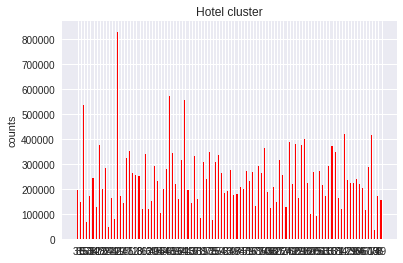

In [39]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
 
repartition_classes = train_nonan.select("hotel_cluster").groupBy("hotel_cluster").count().collect()
categories = [i[0] for i in repartition_classes]
counts = [i[1] for i in repartition_classes]
 
ind = np.array(range(len(categories)))
width = 0.35
plt.bar(ind, counts, width=width, color='r')
 
plt.ylabel('counts')
plt.title('Hotel cluster')
plt.xticks(ind + width/2., categories)

Le fichier destination contient plus d'informations sur les destinations, sauf qu'il contient 147 colonnes, d'où la nécessité de réduire le nombre de features. L'objectif étant d'ajouter des features supplimentaire à la donnée principale

In [41]:
file="drive/My Drive/PLP project/Dreem/destinations.csv"

sqlContext=SQLContext(spark)
tmps1=time.clock()
destinations=sqlContext.read.format('com.databricks.spark.csv').options(delimiter=",").load(file, header = True)
tmps2=time.clock()
destinations.show()

+-------------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+----

Ici, on change le type des colonnes de la table destination

In [0]:
destinations = destinations.withColumn("srch_destination_id", col("srch_destination_id").cast("int"))
for a in destinations.columns[1:]:
  destinations = destinations.withColumn(a, col(a).cast("double"))

## Transformer les 147 colonnes en 3 colonnes à l'aide de PCA


Avant de réduire le nombre des colonnes, il est important de vectoriser 

In [43]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import PCA

assembler = VectorAssembler(inputCols=destinations.columns[1:],outputCol='features')
df=assembler.transform(destinations)
df.select(["srch_destination_id","features"]).show()

+-------------------+--------------------+
|srch_destination_id|            features|
+-------------------+--------------------+
|                  0|[-2.19865708695,-...|
|                  1|[-2.18169033283,-...|
|                  2|[-2.18348974514,-...|
|                  3|[-2.17740922654,-...|
|                  4|[-2.18956170511,-...|
|                  5|[-2.17448889231,-...|
|                  6|[-2.17461039826,-...|
|                  7|[-2.22193170159,-...|
|                  8|[-2.20104721119,-...|
|                  9|[-2.17597860854,-...|
|                 10|[-2.22860590096,-...|
|                 11|[-2.16458487988,-...|
|                 13|[-2.17411524092,-...|
|                 14|[-2.10730356745,-...|
|                 15|[-2.18513746748,-...|
|                 16|[-2.18938090975,-...|
|                 17|[-2.10966824012,-...|
|                 18|[-2.16271008551,-...|
|                 19|[-2.19573507768,-...|
|                 20|[-2.17368975056,-...|
+----------

In [0]:
pca = PCA(k=3, inputCol="features", outputCol="pca_features")
model = pca.fit(df)
transformed = model.transform(df)

In [45]:
transformed.select(["srch_destination_id","pca_features"]).show()

+-------------------+--------------------+
|srch_destination_id|        pca_features|
+-------------------+--------------------+
|                  0|[8.70325491728257...|
|                  1|[8.30676154205389...|
|                  2|[8.74855519416057...|
|                  3|[8.26705550015047...|
|                  4|[8.54026970794172...|
|                  5|[8.19186260729748...|
|                  6|[8.20686369976797...|
|                  7|[9.07314040112431...|
|                  8|[8.81194164625191...|
|                  9|[8.22182613112840...|
|                 10|[9.36477789227971...|
|                 11|[8.67409585780992...|
|                 13|[8.18496518682973...|
|                 14|[8.60752803347898...|
|                 15|[8.54632384441689...|
|                 16|[8.61242087138770...|
|                 17|[9.16794511603699...|
|                 18|[9.00816871546812...|
|                 19|[8.64270807225192...|
|                 20|[8.16615418180893...|
+----------

Séparer PCA features en trois colonnes

In [0]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import ArrayType, DoubleType

def to_array(col):
    def to_array_(v):
        return v.toArray().tolist()
    return udf(to_array_, ArrayType(DoubleType()))(col)
df=transformed.select(["srch_destination_id","pca_features"])
new_detinations=(df
    .withColumn("pca_features", to_array(col("pca_features")))
    .select(["srch_destination_id"] + [col("pca_features")[i] for i in range(3)]))

In [47]:
new_detinations.show()

+-------------------+-----------------+------------------+-------------------+
|srch_destination_id|  pca_features[0]|   pca_features[1]|    pca_features[2]|
+-------------------+-----------------+------------------+-------------------+
|                  0|8.703254917282573| 2.671318791775741| -0.851383727707983|
|                  1|8.306761542053893|2.5793042513193782|-0.9754783117298351|
|                  2|8.748555194160575| 2.522576327822376|-0.8717974933688295|
|                  3|8.267055500150473| 2.461554461742733|-0.9032256995694881|
|                  4|8.540269707941723|2.4592054947830504|-0.8956499106622051|
|                  5|8.191862607297487|2.4696798312021033|-0.9129925799712985|
|                  6|8.206863699767975|  2.46621063827621|-0.9157161483026653|
|                  7|9.073140401124318| 2.310702091032391|-0.6111127093755735|
|                  8|8.811941646251917| 2.392339976482765|-0.7356222522476542|
|                  9|8.221826131128408| 2.4726658141

Générer de nouvelle features se basant sur date_time, srch_ci, and srch_co.

In [48]:
from datetime import datetime
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DateType
# Setting an user define function:
# This function converts the string cell into a date:
func1 =  udf (lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").timestamp(), DoubleType())
func2 =  udf (lambda x: datetime.strptime(x, "%Y-%m-%d").timestamp(), DoubleType())
new_train_nonan= train_nonan.withColumn('date', func1(col('date_time')))
new_train_nonan= new_train_nonan.withColumn('srch_co_new', func2(col("srch_co")))
new_train_nonan= new_train_nonan.withColumn('srch_ci_new', func2(col("srch_ci")))
new_train_nonan.select(["date",'srch_ci_new','srch_co_new']).show()


+-------------+-----------+-----------+
|         date|srch_ci_new|srch_co_new|
+-------------+-----------+-----------+
|1.407743219E9|1.4090976E9|1.4094432E9|
|1.407745332E9|1.4092704E9| 1.409616E9|
|1.407745473E9|1.4092704E9| 1.409616E9|
|1.407607516E9|1.4167008E9|1.4171328E9|
|1.407607698E9|1.4167008E9|1.4171328E9|
|1.407607992E9|1.4167008E9|1.4171328E9|
|1.389939896E9|1.3976928E9| 1.397952E9|
|1.390286348E9|1.3976928E9| 1.397952E9|
|1.390286418E9|1.3977792E9| 1.397952E9|
|1.390371002E9|1.3977792E9| 1.397952E9|
|1.390564324E9|1.3976928E9|1.3978656E9|
|1.413980456E9|1.4141952E9|1.4142816E9|
|1.415623082E9|1.4218848E9|1.4220576E9|
|1.360934323E9| 1.361664E9| 1.362096E9|
| 1.36101587E9| 1.361664E9| 1.362096E9|
|1.361016225E9| 1.361664E9| 1.362096E9|
|1.361017437E9| 1.362096E9| 1.362528E9|
|1.388765955E9|1.3929408E9|1.3933728E9|
|1.388766617E9|1.3930272E9|1.3934592E9|
|1.388766866E9|1.3929408E9|1.3933728E9|
+-------------+-----------+-----------+
only showing top 20 rows



Supprimer les colonnes non numériques comme date_time

In [0]:
new_train_nonan=new_train_nonan.drop('date_time')
new_train_nonan=new_train_nonan.drop("srch_ci")
new_train_nonan=new_train_nonan.drop("srch_co")

Jointure table train et destination

In [0]:
train_join = new_train_nonan.join(new_detinations, new_train_nonan.srch_destination_id == new_detinations.srch_destination_id)

In [51]:
train_join.columns

['site_name',
 'posa_continent',
 'user_location_country',
 'user_location_region',
 'user_location_city',
 'orig_destination_distance',
 'user_id',
 'is_mobile',
 'is_package',
 'channel',
 'srch_adults_cnt',
 'srch_children_cnt',
 'srch_rm_cnt',
 'srch_destination_id',
 'srch_destination_type_id',
 'is_booking',
 'cnt',
 'hotel_continent',
 'hotel_country',
 'hotel_market',
 'hotel_cluster',
 'date',
 'srch_co_new',
 'srch_ci_new',
 'srch_destination_id',
 'pca_features[0]',
 'pca_features[1]',
 'pca_features[2]']

Supprimer les id des destinations

In [0]:
train_join=train_join.drop("srch_destination_id")

In [53]:
train_join.schema

StructType(List(StructField(site_name,IntegerType,true),StructField(posa_continent,IntegerType,true),StructField(user_location_country,IntegerType,true),StructField(user_location_region,IntegerType,true),StructField(user_location_city,IntegerType,true),StructField(orig_destination_distance,DoubleType,true),StructField(user_id,IntegerType,true),StructField(is_mobile,ByteType,true),StructField(is_package,IntegerType,true),StructField(channel,IntegerType,true),StructField(srch_adults_cnt,IntegerType,true),StructField(srch_children_cnt,IntegerType,true),StructField(srch_rm_cnt,IntegerType,true),StructField(srch_destination_type_id,IntegerType,true),StructField(is_booking,ByteType,true),StructField(cnt,LongType,true),StructField(hotel_continent,IntegerType,true),StructField(hotel_country,IntegerType,true),StructField(hotel_market,IntegerType,true),StructField(hotel_cluster,IntegerType,true),StructField(date,DoubleType,true),StructField(srch_co_new,DoubleType,true),StructField(srch_ci_new,Do

## Preparing data for machine learning

Ici, on prépare les données pour l'étape de l'apprentissage. Ceci en transformant toutes les colonnes en une colonne de vecteurs.  


https://runawayhorse001.github.io/LearningApacheSpark/classification.html

In [0]:
def get_dummy(df,categoricalCols,continuousCols,labelCol):

    from pyspark.ml import Pipeline
    from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
    from pyspark.sql.functions import col

    indexers = [ StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
                 for c in categoricalCols ]

    # default setting: dropLast=True
    encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(),
                 outputCol="{0}_encoded".format(indexer.getOutputCol()))
                 for indexer in indexers ]

    assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders]
                                + continuousCols, outputCol="features")

    pipeline = Pipeline(stages=indexers + encoders + [assembler])

    model=pipeline.fit(df)
    data = model.transform(df)

    data = data.withColumn('label',col(labelCol))

    return data.select('features','label')

In [58]:
catcols = []

num_cols = [train_join.columns[i] for i in range(len(train_join.columns)) if train_join.columns[i]!="hotel_cluster"]

labelCol = "hotel_cluster"

data = get_dummy(train_join,catcols,num_cols,labelCol)
data.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[2.0,3.0,66.0,348...|    1|
|[2.0,3.0,66.0,348...|    1|
|[2.0,3.0,66.0,348...|    1|
|[2.0,3.0,66.0,442...|   80|
|[2.0,3.0,66.0,442...|   21|
+--------------------+-----+
only showing top 5 rows



## Réduction de la taille des données et apprentissage


Nous avons essayé dans un premier temps de faire l'apprentissage sur toutes les données. Or, l'étape d'apprentissage avait pris plus que 1h30 mins, et avons décidé de réduire la taille des données pour avoir une simple démonstration de l'apprentissage avec Spark.

In [0]:
data_r=spark.createDataFrame(data.take(3000))

In [61]:
from pyspark.ml.feature import StringIndexer
# Index labels, adding metadata to the label column
labelIndexer = StringIndexer(inputCol='label',
                             outputCol='indexedLabel').fit(data_r)
labelIndexer.transform(data_r).show(5, True)

+--------------------+-----+------------+
|            features|label|indexedLabel|
+--------------------+-----+------------+
|[2.0,3.0,66.0,348...|    1|        78.0|
|[2.0,3.0,66.0,348...|    1|        78.0|
|[2.0,3.0,66.0,348...|    1|        78.0|
|[2.0,3.0,66.0,442...|   80|        27.0|
|[2.0,3.0,66.0,442...|   21|         6.0|
+--------------------+-----+------------+
only showing top 5 rows



In [63]:
from pyspark.ml.feature import VectorIndexer
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =VectorIndexer(inputCol="features", \
                                  outputCol="indexedFeatures", \
                                  maxCategories=4).fit(data_r)
featureIndexer.transform(data_r).show(5, True)

+--------------------+-----+--------------------+
|            features|label|     indexedFeatures|
+--------------------+-----+--------------------+
|[2.0,3.0,66.0,348...|    1|[2.0,2.0,66.0,348...|
|[2.0,3.0,66.0,348...|    1|[2.0,2.0,66.0,348...|
|[2.0,3.0,66.0,348...|    1|[2.0,2.0,66.0,348...|
|[2.0,3.0,66.0,442...|   80|[2.0,2.0,66.0,442...|
|[2.0,3.0,66.0,442...|   21|[2.0,2.0,66.0,442...|
+--------------------+-----+--------------------+
only showing top 5 rows



In [0]:
(trainingData, testData) = data_r.randomSplit([0.7, 0.3])

In [0]:
from pyspark.ml.classification import LogisticRegression
logr = LogisticRegression(featuresCol='indexedFeatures', labelCol='indexedLabel')

In [0]:
from pyspark.ml.feature import IndexToString, StringIndexer
# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

In [0]:
# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, logr,labelConverter])

In [71]:
trainingData.count()

2108

In [0]:
# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

In [73]:
# Make predictions.
predictions = model.transform(testData)
# Select example rows to display.
predictions.select("features","label","predictedLabel").show(5)

+--------------------+-----+--------------+
|            features|label|predictedLabel|
+--------------------+-----+--------------+
|[2.0,3.0,66.0,143...|   44|            91|
|[2.0,3.0,66.0,143...|   98|            91|
|[2.0,3.0,66.0,143...|   97|            95|
|[2.0,3.0,66.0,143...|   99|            34|
|[2.0,3.0,66.0,143...|   30|            20|
+--------------------+-----+--------------+
only showing top 5 rows



In [74]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.848655
